In [441]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
cmap = plt.cm.RdBu
torch.autograd.set_detect_anomaly(True)
#plt.style.use("dark_paper")

In [442]:
def f(x):
    ret = np.zeros(len(x))
    for i,dat in enumerate(x):
        #ret[i] = 2*(len(dat[dat>0.5]) % 2) - 1
        #ret[i] = 2*(np.prod(dat) >= 0.5**(len(dat))) - 1
        ret[i] = np.prod(dat)/(0.5**len(dat))
    return ret

In [443]:
class PIN1(nn.Module):
    def __init__(self, N, width=10):
        super(PIN1, self).__init__()
        self.phiW = nn.Parameter( torch.randn(N+1) )
        self.phiB = nn.Parameter( torch.randn(N+1) )      
        self.rho = nn.Linear(N+1,1)
        self.N = N
        print('Constructor')

    def forward(self, x):
        
        W1 = torch.ones((self.N+1,self.N))
        B1 = torch.ones(self.N+1)
        for i in range(self.N+1):
            W1[i] *= self.phiW[i]
            B1[i] *= self.phiB[i]
        
        W1 = torch.transpose(W1,0,1)
        
        x = torch.add(torch.matmul(x,W1),B1)
        x = nn.ReLU()(x)
        x = self.rho(x)
        return x
    
class PIN2(nn.Module):
    def __init__(self, N, depth=10):
        super(PIN2, self).__init__()
        self.eqvL = nn.Parameter( torch.randn(depth) )
        self.eqvG = nn.Parameter( torch.randn(depth) )
        self.N = N
        self.depth = depth

    def forward(self, x):
        

        for i in range(self.depth):
            L = self.eqvL[i]*torch.eye(self.N)
            G = self.eqvG[i]*torch.ones((self.N,self.N))
            x = torch.matmul(x,L+G)
            x = torch.nn.ReLU()(x)
        out = torch.sum(x,1)
        return out

    
class SNN(nn.Module):
    def __init__(self, N, width=3):
        super(SNN,self).__init__()
        self.mlp = torch.nn.Sequential(torch.nn.Linear(N,N+1),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(N+1,1))
    def forward(self,x):
        x = self.mlp(x)
        return x

In [470]:
N = 3
M = int(10000)
BS = 10

np.random.seed(7)

xtrain = np.random.rand(M,N)
xval = np.random.rand(M,N)

ytrain = f(xtrain)
yval = f(xval)

xtrain = torch.from_numpy(xtrain).float()
ytrain = torch.from_numpy(ytrain).float().view(-1,1)
xval = torch.from_numpy(xval).float()
yval = torch.from_numpy(yval).float().view(-1,1)

trainset = torch.utils.data.TensorDataset(xtrain,ytrain)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BS,
                                          shuffle=True)

valset = torch.utils.data.TensorDataset(xval,yval)
valloader = torch.utils.data.DataLoader(valset,batch_size=BS)

In [467]:
mlp = SNN(N)
pin = PIN1(N)
criterion = torch.nn.MSELoss(reduction="mean")
optimizer_mlp = torch.optim.SGD(mlp.parameters(),lr=1e-2)
optimizer_pin = torch.optim.SGD(pin.parameters(),lr=1e-2)

Constructor


In [468]:
# Define training and validation functions
def train(model,optimizer,x,y):
    model.train()
    yhat = model(x)
    loss = criterion(yhat,y.view(-1,1))
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
def validate(model,x,y):
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat,y.view(-1,1))
        return loss.item()
    
# Define early stopping function
def earlyStop(loss_vec,N,eps=1e-3):
    for i in range(N):
        if loss_vec[-i-2] > loss_vec[-i-1]*(1+eps): return False
    return True

Epoch 010/100000 | Training loss mlp/pin: 1.372320/2.090641 - Validation loss mlp/pin: 1.390339/2.054944
Epoch 020/100000 | Training loss mlp/pin: 1.198175/1.381785 - Validation loss mlp/pin: 1.220253/1.385584
Epoch 030/100000 | Training loss mlp/pin: 1.123443/1.114679 - Validation loss mlp/pin: 1.146767/1.133702
Epoch 040/100000 | Training loss mlp/pin: 1.089760/1.032282 - Validation loss mlp/pin: 1.112506/1.055400
Epoch 050/100000 | Training loss mlp/pin: 1.068909/1.003880 - Validation loss mlp/pin: 1.090882/1.026539
Epoch 060/100000 | Training loss mlp/pin: 1.051546/0.985013 - Validation loss mlp/pin: 1.072990/1.007042
Epoch 070/100000 | Training loss mlp/pin: 1.035016/0.967639 - Validation loss mlp/pin: 1.056152/0.989344
Epoch 080/100000 | Training loss mlp/pin: 1.018611/0.950471 - Validation loss mlp/pin: 1.039575/0.972026
Epoch 090/100000 | Training loss mlp/pin: 1.002146/0.933316 - Validation loss mlp/pin: 1.023012/0.954798
Epoch 100/100000 | Training loss mlp/pin: 0.985575/0.91

Epoch 800/100000 | Training loss mlp/pin: 0.308403/0.357761 - Validation loss mlp/pin: 0.325846/0.374405
Epoch 810/100000 | Training loss mlp/pin: 0.306488/0.357228 - Validation loss mlp/pin: 0.323843/0.373819
Epoch 820/100000 | Training loss mlp/pin: 0.304605/0.356739 - Validation loss mlp/pin: 0.321877/0.373268
Epoch 830/100000 | Training loss mlp/pin: 0.302764/0.356273 - Validation loss mlp/pin: 0.319952/0.372749
Epoch 840/100000 | Training loss mlp/pin: 0.300971/0.355835 - Validation loss mlp/pin: 0.318072/0.372261
Epoch 850/100000 | Training loss mlp/pin: 0.299216/0.355420 - Validation loss mlp/pin: 0.316220/0.371801
Epoch 860/100000 | Training loss mlp/pin: 0.297476/0.355026 - Validation loss mlp/pin: 0.314384/0.371365
Epoch 870/100000 | Training loss mlp/pin: 0.295762/0.354649 - Validation loss mlp/pin: 0.312582/0.370948
Epoch 880/100000 | Training loss mlp/pin: 0.294058/0.354294 - Validation loss mlp/pin: 0.310789/0.370557
Epoch 890/100000 | Training loss mlp/pin: 0.292345/0.35

Epoch 1580/100000 | Training loss mlp/pin: 0.165046/0.331104 - Validation loss mlp/pin: 0.182329/0.346832
Epoch 1590/100000 | Training loss mlp/pin: 0.163600/0.330545 - Validation loss mlp/pin: 0.180873/0.346244
Epoch 1600/100000 | Training loss mlp/pin: 0.162190/0.329966 - Validation loss mlp/pin: 0.179447/0.345636
Epoch 1610/100000 | Training loss mlp/pin: 0.160798/0.329369 - Validation loss mlp/pin: 0.178044/0.345011
Epoch 1620/100000 | Training loss mlp/pin: 0.159425/0.328758 - Validation loss mlp/pin: 0.176665/0.344366
Epoch 1630/100000 | Training loss mlp/pin: 0.158079/0.328138 - Validation loss mlp/pin: 0.175314/0.343707
Epoch 1640/100000 | Training loss mlp/pin: 0.156743/0.327510 - Validation loss mlp/pin: 0.173979/0.343039
Epoch 1650/100000 | Training loss mlp/pin: 0.155426/0.326870 - Validation loss mlp/pin: 0.172668/0.342359
Epoch 1660/100000 | Training loss mlp/pin: 0.154149/0.326219 - Validation loss mlp/pin: 0.171393/0.341671
Epoch 1670/100000 | Training loss mlp/pin: 0.1

Epoch 2360/100000 | Training loss mlp/pin: 0.112231/0.212576 - Validation loss mlp/pin: 0.127390/0.230212
Epoch 2370/100000 | Training loss mlp/pin: 0.112003/0.210423 - Validation loss mlp/pin: 0.127129/0.228117
Epoch 2380/100000 | Training loss mlp/pin: 0.111782/0.208298 - Validation loss mlp/pin: 0.126875/0.226041
Epoch 2390/100000 | Training loss mlp/pin: 0.111566/0.206201 - Validation loss mlp/pin: 0.126627/0.223987
Epoch 2400/100000 | Training loss mlp/pin: 0.111354/0.204121 - Validation loss mlp/pin: 0.126379/0.221945
Epoch 2410/100000 | Training loss mlp/pin: 0.111145/0.202073 - Validation loss mlp/pin: 0.126135/0.219931
Epoch 2420/100000 | Training loss mlp/pin: 0.110940/0.200057 - Validation loss mlp/pin: 0.125897/0.217942
Epoch 2430/100000 | Training loss mlp/pin: 0.110739/0.198073 - Validation loss mlp/pin: 0.125660/0.215977
Epoch 2440/100000 | Training loss mlp/pin: 0.110542/0.196110 - Validation loss mlp/pin: 0.125429/0.214034
Epoch 2450/100000 | Training loss mlp/pin: 0.1

Epoch 3140/100000 | Training loss mlp/pin: 0.102878/0.125297 - Validation loss mlp/pin: 0.116186/0.141393
Epoch 3150/100000 | Training loss mlp/pin: 0.102824/0.124946 - Validation loss mlp/pin: 0.116118/0.141000
Epoch 3160/100000 | Training loss mlp/pin: 0.102770/0.124605 - Validation loss mlp/pin: 0.116051/0.140616
Epoch 3170/100000 | Training loss mlp/pin: 0.102718/0.124274 - Validation loss mlp/pin: 0.115986/0.140243
Epoch 3180/100000 | Training loss mlp/pin: 0.102666/0.123952 - Validation loss mlp/pin: 0.115919/0.139877
Epoch 3190/100000 | Training loss mlp/pin: 0.102615/0.123632 - Validation loss mlp/pin: 0.115854/0.139512
Epoch 3200/100000 | Training loss mlp/pin: 0.102565/0.123318 - Validation loss mlp/pin: 0.115790/0.139160
Epoch 3210/100000 | Training loss mlp/pin: 0.102516/0.123013 - Validation loss mlp/pin: 0.115725/0.138822
Epoch 3220/100000 | Training loss mlp/pin: 0.102467/0.122719 - Validation loss mlp/pin: 0.115662/0.138494
Epoch 3230/100000 | Training loss mlp/pin: 0.1

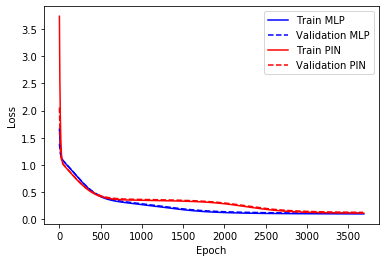

In [469]:
# Train the model for 100 epochs 
T = 100000
V = 10
ES = 10
losses_train_mlp = []
losses_val_mlp = []
losses_train_pin = []
losses_val_pin = []
mlp.train()
for t in range(1,T+1):
    #loss_mlp = 0
    #loss_pin = 0
    #for n,(x,y) in enumerate(trainloader):
    #    loss_mlp += train(mlp,optimizer_mlp,x,y)
    #    loss_pin += train(pin,optimizer_pin,x,y)
    loss_mlp = train(mlp,optimizer_mlp,xtrain,ytrain)
    loss_pin = train(pin,optimizer_pin,xtrain,ytrain)
    losses_train_mlp.append(loss_mlp)
    losses_train_pin.append(loss_pin)
    if t%V == 0:
        print(f"Epoch {t:>03d}/{T:^3d} | Training loss mlp/pin: {loss_mlp:^.6f}/{loss_pin:^.6f}", end=" - ") #,end="\r"
        mlp.eval()
        with torch.no_grad():
            yhat = mlp(xval)
            loss_mlp = criterion(yhat,yval.view(-1,1)).item()
            yhat = pin(xval)
            loss_pin = criterion(yhat,yval.view(-1,1)).item()
        losses_val_mlp.append(loss_mlp)
        losses_val_pin.append(loss_pin)
        print(f"Validation loss mlp/pin: {loss_mlp:^.6f}/{loss_pin:^.6f}") #,end="\r"
    if t/V>ES+1:
        if earlyStop(losses_val_mlp,ES) and earlyStop(losses_val_pin,ES): break
plt.plot(np.arange(0,t),losses_train_mlp,label="Train MLP",color='blue')
plt.plot(np.arange(0,t,V),losses_val_mlp,label="Validation MLP",color='blue',linestyle='--')
plt.plot(np.arange(0,t),losses_train_pin,label="Train PIN",color='red')
plt.plot(np.arange(0,t,V),losses_val_pin,label="Validation PIN",color='red',linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

/home/nwkamp/.local/lib/python3.6/site-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


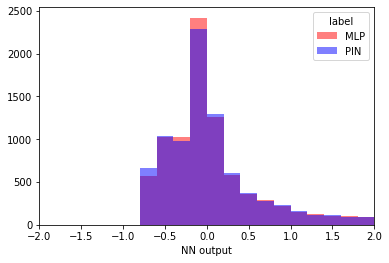

In [471]:
# Let's take a look at how our model performs
out_mlp = mlp(xval).squeeze()
out_pin = pin(xval).squeeze()

yval = yval.resize(len(yval))

frac_error_mlp = torch.div((out_mlp-yval),yval)
frac_error_pin = torch.div((out_pin-yval),yval)

plt.hist(frac_error_mlp.detach().numpy(),bins=20,range=(-2,2),alpha=0.5,color='red',label="MLP")
plt.hist(frac_error_pin.detach().numpy(),bins=20,range=(-2,2),alpha=0.5,color='blue',label="PIN")
plt.xlim(-2,2)
plt.legend(title="label")
#plt.yscale("log")
plt.xlabel("NN output")
plt.show()

Parameter containing:
tensor([[ 0.5664,  0.5616,  0.5371],
        [ 1.2335,  1.2372,  1.2180],
        [ 0.0588, -0.4115, -0.4125],
        [-0.4622, -0.1546,  0.0208]], requires_grad=True)
Parameter containing:
tensor([[ 1.4455,  2.7283, -0.2370, -0.1071]], requires_grad=True)
0
100
200
300
400
500
600
700
800
900


(array([578., 141.,  96.,  54.,  26.,  30.,  16.,  14.,   6.,   7.,   5.,
          7.,   6.,   5.,   5.,   1.,   1.,   1.,   1.,   0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ],
       dtype=float32),
 <a list of 20 Patch objects>)

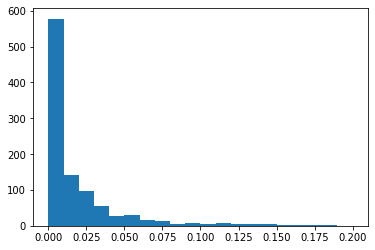

In [474]:
# Now we will print the weights of the hidden layer
modules = list(mlp.modules())
print(modules[0].mlp[0].weight)
print(modules[0].mlp[2].weight)

from itertools import permutations

rm_mlp = []
rm_pin = []

for i in range(1000):
    if(i%100==0): print(i)
    test = np.random.random(N)

    test_permuted = np.array([np.array(p) for p in list(permutations(test))])
    y = f(test_permuted)
    yhat_mlp = np.array([mlp(torch.from_numpy(test).float()).detach().numpy() for test in test_permuted])
    rm_mlp.append((np.max(yhat_mlp) - np.min(yhat_mlp))/np.mean(yhat_mlp))
    
plt.hist(rm_mlp,bins=20,range=(0,0.2))

    
